In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("/home/torsten/ms/data/rosbag2_2024_01_05-12_47_24/imu.csv")
df

,timestamp,la_x,la_y,la_z,av_x,av_y,av_z
0,1704451644719,-0.191261,0.061345,9.760426,-0.000861,0.001362,-0.000441
1,1704451644724,-0.188873,0.051794,9.772343,0.000712,0.003470,-0.001527
2,1704451644729,-0.196105,0.042183,9.765161,-0.001909,0.000296,-0.002057
3,1704451644734,-0.212819,0.037281,9.760412,0.000224,-0.001243,0.002822
4,1704451644739,-0.207907,0.039692,9.758081,0.000740,0.001367,-0.001518
...,...,...,...,...,...,...,...
102397,1704452277557,-0.040971,0.117439,9.776880,0.000710,0.000431,-0.001050
102398,1704452277696,-0.007406,0.127229,9.769741,-0.000323,-0.001666,0.002183
102399,1704452277823,-0.029032,0.115132,9.788787,0.000697,0.000967,0.001630
102400,1704452277843,-0.029101,0.119923,9.772065,-0.001935,-0.000634,0.000008


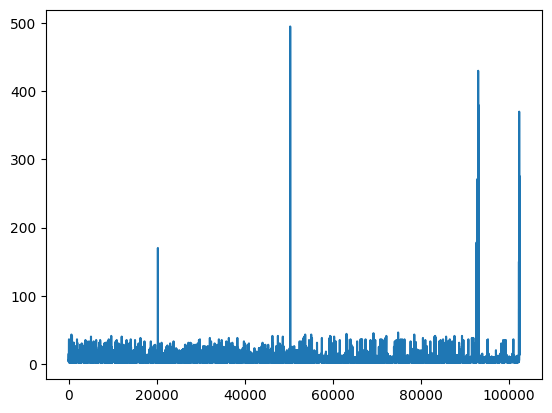

In [3]:
plt.figure()
plt.plot(np.diff(df.iloc[:, 0]))
plt.show()

May 2023: Linear acceleration and angular velocity were changed around in the ROS message.  
Stereolabs claim coord system to be Axis: X FORWARD, Y LEFT, Z UP.  
It looks like X points down

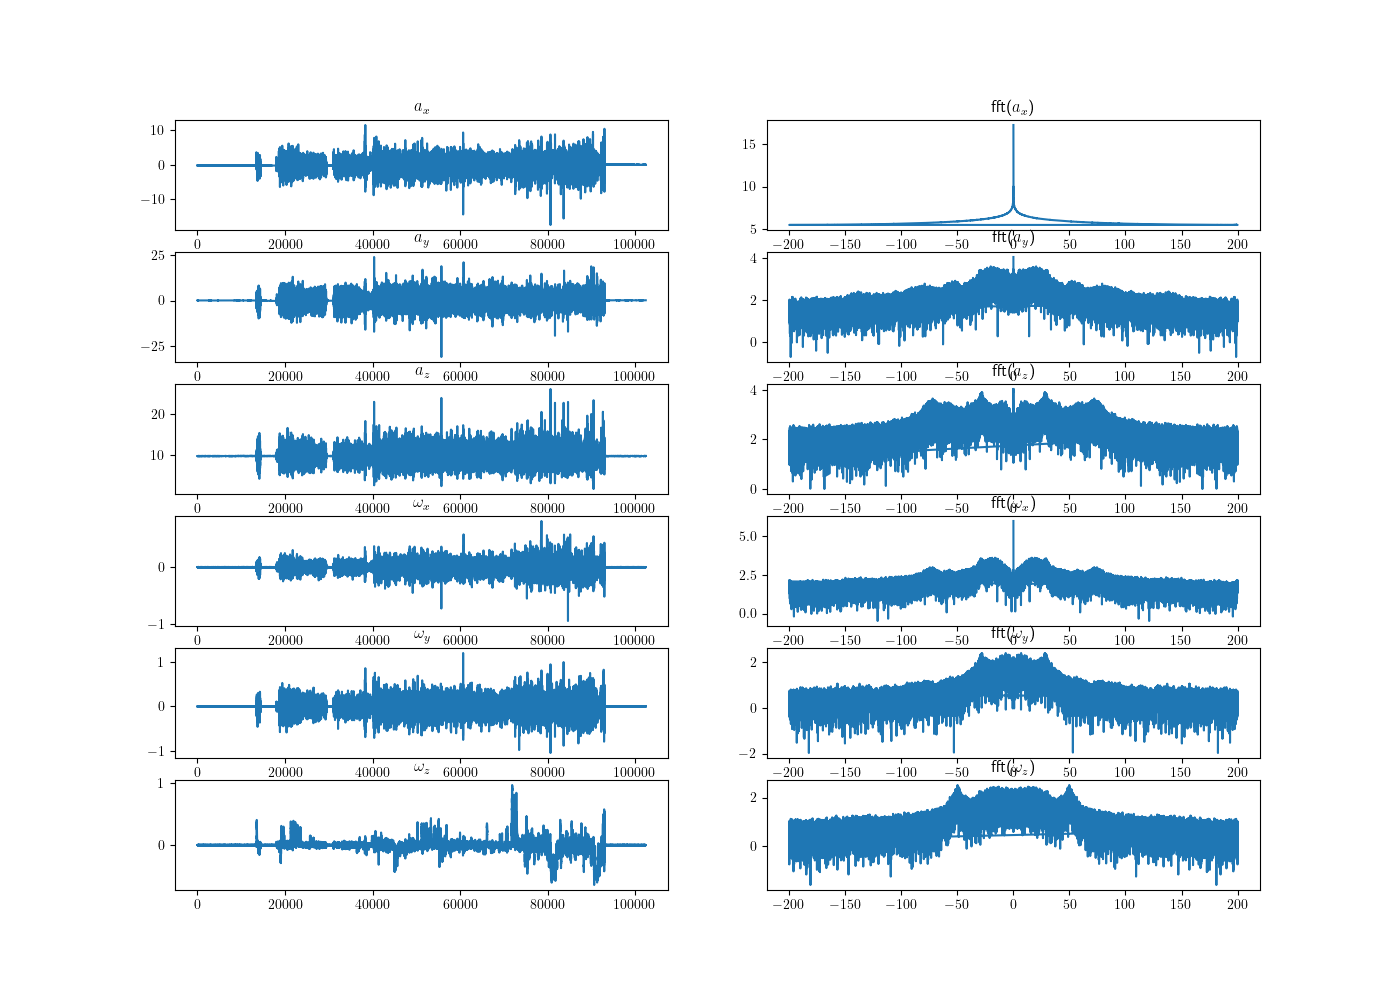

In [4]:
%matplotlib widget
plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
titles = [
    "$a_x$",
    "$a_y$",
    "$a_z$",
    "$\omega_x$",
    "$\omega_y$",
    "$\omega_z$",]

plt.figure(figsize=(14,10))
for i in range(6):
    plt.subplot(6,2,i*2+1)
    plt.title(titles[i])
    plt.plot(df.iloc[:,i+1])
    plt.subplot(6,2,i*2+2)
    plt.title("fft("+titles[i]+")")
    plt.plot(np.fft.fftfreq(df.iloc[:,i].shape[0], 1/400),np.log10(np.abs(np.fft.fft(df.iloc[:,i].values))))
plt.show()
         

# Basic attempt at dead reckoning
Try a two dimensional integration with rotaion around vertial axis and movement forward and back. Use $\omega_x$ as rotational axis and $a_y$ as forward/backward acceleration.

In [17]:
w_x = df.iloc[:,6].values
a_y = df.iloc[:,2].values - 0.075

pos = np.asarray([0, 0], dtype=float) #(x, y)
vel = 0 #m/s
O = 0 # rad/s orientation
dt = 1/200

pos_history = np.zeros((w_x.shape[0], 2))
vel_history = np.zeros((w_x.shape[0], 1))

for i in range(w_x.shape[0]):
    vel += a_y[i] * dt
    vel_history[i] = vel
    delta_s = vel * dt # Displacement at timestep

    O += w_x[i] * dt # Orientation
    delta_x = np.asarray([np.cos(O), np.sin(O)], dtype=float) * delta_s
    pos += delta_x
    pos_history[i, 0] = pos[0]
    pos_history[i, 1] = pos[1]    


<function matplotlib.pyplot.show(block=None)>

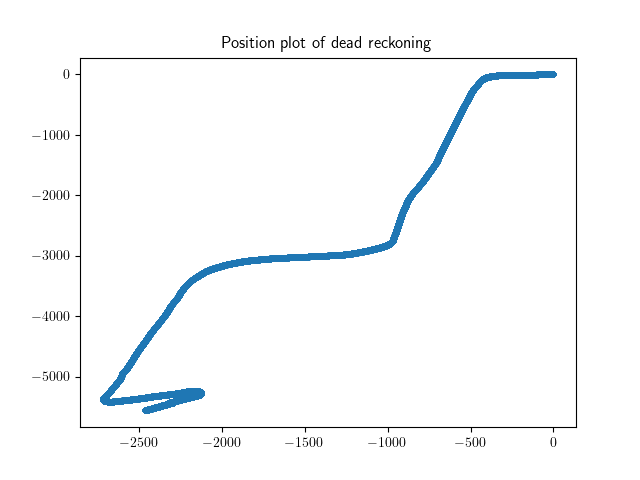

In [18]:
plt.figure()
plt.title("Position plot of dead reckoning")
plt.scatter(pos_history[:, 0], pos_history[:, 1], marker=".")
plt.show

<function matplotlib.pyplot.show(block=None)>

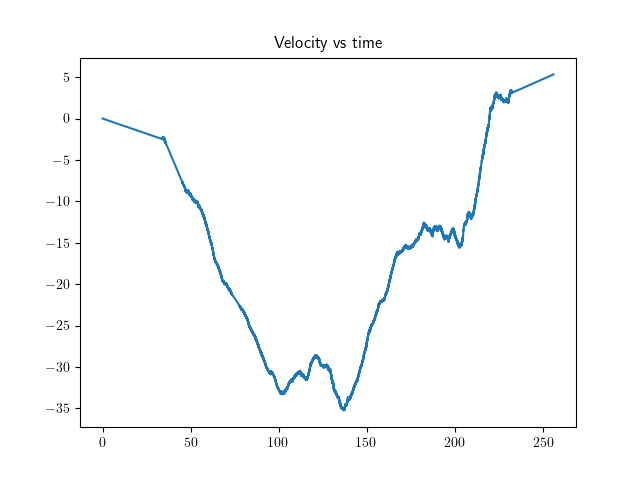

In [19]:
plt.figure()
plt.title("Velocity vs time")
t = np.arange(vel_history.shape[0]) * (1/400)
plt.plot(t, vel_history)
plt.show

# Finding gravity vector

<function matplotlib.pyplot.show(block=None)>

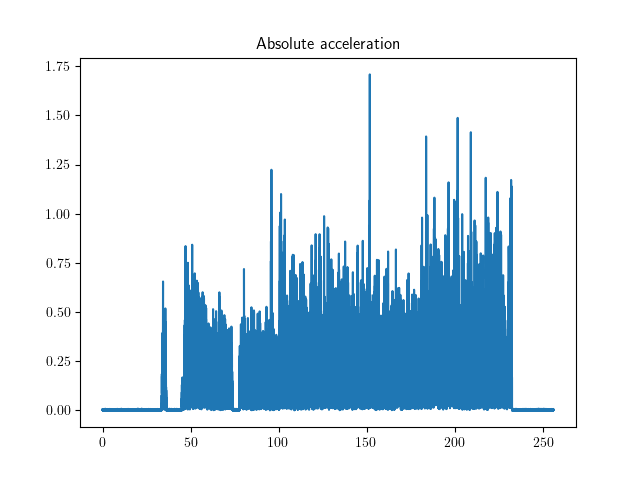

In [20]:
abs_a = np.sqrt(np.power(df.iloc[:,4].values, 2) + np.power(df.iloc[:,5].values, 2) + np.power(df.iloc[:,5].values, 2))

plt.figure()
plt.title("Absolute acceleration")
plt.plot(t, abs_a)
plt.show